# MicroKWS Training Flow

This notebook should give an introduction on the required procedure to design, train and quantize a small machine learning model using the Tensorflow Lite and the Keras API. The application example is a keyword-spotting (KWS) task which should ideally be suitable to run on an energy efficent device e.g. a small microcontroller platform (see next lab).

In the following a step by step guide is provided. Please follow the notebooks contents sequentially by executiong one cell after each other while inspecting the used python code as well as the program outputs printed to the screen. From time to time theoretical tasks are going to be introduced. Please try to answer them **without changing the contents of the previous cells**. At the end of this document, there is a Programming Challenge which has to be solved alongside with the previous theoretical questions to pass this lab assignment. As this challenge involves some programming, it is recommended to duplicate this notebook before starting to play around with the code in the allowed cells.

If you have never heard of *Jupyter Notebooks* before, please first have a look at the Setup section in the Lab Manual and check out https://docs.jupyter.org/en/latest/start/index.html for more information.

### Disclaimer

This tutorial is inpired by the contents of: https://github.com/ARM-software/ML-examples/tree/main/tflu-kws-cortex-m/Training

## 0. Install software

The following steps should ideally done before launching this Jupyter notebook! (See `README.md`!)

**1. Clone repository**

```
git clone git@gitlab.lrz.de:de-tum-ei-eda-esl/ESD4ML/micro-kws.git
```


**2. Create virtual python environment**

```
virtualenv -p python3.8 venv
```

**3. Enter virtual python environment**

```
source venv/bin/activate
```

**4. Enter directory**

```
cd micro-kws/1_train
```

**5. Install python packages into environment**

```
pip install -r requirements.txt
```

**6. Start jupyter notebook**
    
```
jupyter notebook Flow.ipynb
```

  If using a remote host, append: ` --no-browser --ip 0.0.0.0 --port XXXX` (where XXXX should be a number greater than 1000)
  
  If you experience warnings it might help to use ` --NotebookApp.iopub_msg_rate_limit=1.0e10  --NotebookApp.iopub_data_rate_limit=1.0e10`

The following "IPython magic" allows editing python files without restarting the Jupyter kernel.

In [1]:
%load_ext autoreload
%autoreload 2

## 1. Python imports

Python builtin dependencies

In [2]:
import os
import tempfile

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"  # Reduce verbosity
import argparse
from pathlib import Path

Third party dependencies

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2023-12-03 23:26:48.064429: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/openrobots/lib:/opt/openrobots/lib:/home/almo/ros/leggedrobot/devel/lib:/home/almo/ros/redballblueball/devel/lib:/home/almo/ros/multisensory_ws/devel/lib:/opt/ros/noetic/lib
2023-12-03 23:26:48.391968: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/openrobots/lib:/opt/openrobots/lib:/home/almo/ros/leggedrobot/devel/lib:/home/almo/ros/redballblueball/devel/lib:/home/almo/ros/multisensory_ws/devel/lib:/opt/ros/noetic/lib
2023-12-03 23:26:48.392003: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dyna

Jupyter specific

In [4]:
from IPython.display import FileLink

Helper scripts

In [5]:
import data
import models
from test import get_accuracy, get_confusion_matrix
from test_tflite import tflite_test
from estimate import load_model, estimate_model_macs, estimate_model_rom, estimate_model_ram

Import student code

In [6]:
from student.metrics import get_student_metrics
from student.callbacks import get_student_callbacks

## 2. Define training parameters

In this section the hyperparameters for the model and training procedure are defined. Feel free to read through the code line by line as the options should be all documented well. You are NOT supposed to change any parameters except the following:

- `FLAGS.model_name`: This will be used as the base filename when writing the converted model to the disk. Change this from `"kws_model_xs"` to `kws_model_student` when starting the Programming challenge.
- `FLAGS.data_dir`: May be changed to a persitent directory to keep the downloaded dataset between reboots if working on a personal machine. If working on a chair computer, feel free to change this to `/usr/local/labs/ESD4ML/current/common/data/speech_commands_v0.02` to skip the download procedure.
- `FLAGS.wanted_words`: should be changed to the set of keywords which was assigned to your group **after** answering the theoretical questions on the default pair of keywords.

In [7]:
FLAGS = argparse.Namespace()

# Overwrite the model name provided by keras with a custom one
FLAGS.model_name = "kws_model_student"

# Location of speech training data archive on the web.
FLAGS.data_url = "http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz"

# Where to download the speech training data to.
try:
    login = os.getlogin()
except:
    login = "unknown"
FLAGS.data_dir = os.getenv(
    "SPEECH_COMMANDS_DIR",
    default=os.path.join(tempfile.gettempdir(), login, "speech_dataset"),
)

# Words to use (others will be added to an unknown label)
FLAGS.wanted_words = "on,left,right,yes,off,down,no,up"

# Total number of classifiations labels (wanted_words + silence + unknown)
FLAGS.num_classes = len(FLAGS.wanted_words.split(",")) + 2

# How loud the background noise should be, between 0 and 1.
FLAGS.background_volume = 0.1

# How many of the training samples have background noise mixed in.
FLAGS.background_frequency = 0.8

# How much of the training data should be silence.
FLAGS.silence_percentage = 100.0 / FLAGS.num_classes

# How much of the training data should be unknown words
FLAGS.unknown_percentage = 100.0 / FLAGS.num_classes

# Range to randomly shift the training audio by in time.
FLAGS.time_shift_ms = 100.0

# What percentage of wavs to use as a test set.
FLAGS.testing_percentage = 10

# What percentage of wavs to use as a validation set.
FLAGS.validation_percentage = 10

# Expected sample rate of the wavs
FLAGS.sample_rate = 16000

# Expected duration in milliseconds of the wavs
FLAGS.clip_duration_ms = 1000

# How long each spectrogram timeslice is
FLAGS.window_size_ms = 30.0

# How long each spectrogram timeslice is
FLAGS.window_stride_ms = 20.0

# How many bins to use for the MFCC fingerprint
FLAGS.dct_coefficient_count = 40

# How many training loops to run
FLAGS.how_many_training_steps = "12000,3000"

# How often to evaluate the training results.
FLAGS.eval_step_interval = 400

# How large a learning rate to use when training.
FLAGS.learning_rate = "0.001,0.0001"

# How many items to train with at once
FLAGS.batch_size = 100

# Where to save summary logs for TensorBoard.
# FLAGS.summaries_dir = '/tmp/retrain_logs'

# Directory to write event logs and checkpoint.
FLAGS.train_dir = "training"

# Directory to write converted models to.
FLAGS.models_dir = "models"

## 3. Create Keras Model

Get the model settings as they are required for the preprocessing, training and quantization.

In [8]:
model_settings = models.prepare_model_settings(
    len(data.prepare_words_list(FLAGS.wanted_words.split(","))),
    FLAGS.sample_rate,
    FLAGS.clip_duration_ms,
    FLAGS.window_size_ms,
    FLAGS.window_stride_ms,
    FLAGS.dct_coefficient_count,
)

Define a model architecture using the Keras API. A predefined model can be found in `models.py`. The model for the final challenge has to be defined in `student/model.py`

The following is just an example on how to define a minimal model architecture for the MicroTVM application:

```python
def create_micro_kws_xs_model(model_settings):
    """Builds a model with a single depthwise-convolution layer followed by a single fully-connected layer.
    Args:
        model_settings: Dict of different settings for model training.
    Returns:
        tf.keras Model of the 'micro_kws_xs' architecture.
    """

    # Get relevant model setting.
    input_frequency_size = model_settings["dct_coefficient_count"]
    input_time_size = model_settings["spectrogram_length"]

    inputs = tf.keras.Input(shape=(model_settings["fingerprint_size"]), name="input")

    # Reshape the flattened input.
    x = tf.reshape(inputs, shape=(-1, input_time_size, input_frequency_size, 1))

    # First convolution.
    x = tf.keras.layers.DepthwiseConv2D(
        depth_multiplier=4,
        kernel_size=(5, 4),
        strides=(2, 2),
        padding="SAME",
        activation="relu",
    )(x)

    # Flatten for fully connected layers.
    x = tf.keras.layers.Flatten()(x)

    # Output fully connected.
    output = tf.keras.layers.Dense(units=model_settings["label_count"], activation="softmax")(x)

    return tf.keras.Model(inputs, output, name=FLAGS.model_name)
```

Generate keras model. The `model.summary()` utility provides a way to inspect the layers of Keras model with its shapes and parameters.

In [9]:
model = models.get_model(model_settings,"micro_kws_student",  model_name=FLAGS.model_name)
model.summary()

Model: "kws_model_student"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1960)]            0         
                                                                 
 tf.reshape (TFOpLambda)     (None, 49, 40, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 49, 40, 32)        672       
                                                                 
 tf.quantization.fake_quant_  (None, 49, 40, 32)       0         
 with_min_max_args (TFOpLamb                                     
 da)                                                             
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 20, 32)       0         
 )                                                               
                                                 

2023-12-03 23:26:49.131086: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/openrobots/lib:/opt/openrobots/lib:/home/almo/ros/leggedrobot/devel/lib:/home/almo/ros/redballblueball/devel/lib:/home/almo/ros/multisensory_ws/devel/lib:/opt/ros/noetic/lib
2023-12-03 23:26:49.131122: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/openrobots/lib:/opt/openrobots/lib:/home/almo/ros/leggedrobot/devel/lib:/home/almo/ros/redballblueball/devel/lib:/home/almo/ros/multisensory_ws/devel/lib:/opt/ros/noetic/lib
2023-12-03 23:26:49.131143: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dyna

## 4. Prepare dataset

While keyword-spotting is quite simple tasks, the preprocessing to generate input features for training is non-trivial. Hence, the implementation of the `Audioprocessor()` class is omited here. If interested, check out the [`data.py`](./data.py) script for more information.

One aspect, which is very important here is the `micro=True` option as it ensures that the same preprocessing (conversion of input WAV files to an Image) is applied to the input dataset as used in the mcirocontroller target software.

In [10]:
# Changing directory if running on T's computer 

if os.path.exists('/media/almo'):
    FLAGS.data_dir = r"/media/almo/Windows/Users/Thien/Documents/MSNE/WS23_ESD4ML/speech_dataset"

print(FLAGS.data_dir) #/tmp/almo/speech_dataset 

# FLAGS.how_many_training_steps = "3000,1000"


/media/almo/Windows/Users/Thien/Documents/MSNE/WS23_ESD4ML/speech_dataset


In [11]:
audio_processor = data.AudioProcessor(
    data_url=FLAGS.data_url,
    data_dir=FLAGS.data_dir,
    silence_percentage=FLAGS.silence_percentage,
    unknown_percentage=FLAGS.unknown_percentage,
    wanted_words=FLAGS.wanted_words.split(","),
    validation_percentage=FLAGS.validation_percentage,
    testing_percentage=FLAGS.testing_percentage,
    model_settings=model_settings,
    micro=True,
)

Let's define a helper function to visualize some features:

In [12]:
def visualize_feature(feature):
    # Utility to display a given feature from the dataset inside the notebook
    feature_data, feature_label = feature

    feature_data = feature_data.numpy()
    feature_label = feature_label.numpy()

    feature_label_str = (["silence", "unknown"] + FLAGS.wanted_words.split(","))[feature_label]

    feature_reshaped = np.reshape(feature_data, (49, 40)).T

    p = plt.imshow(feature_reshaped, cmap="gray", vmin=0, vmax=26)
    plt.title(f"Label: {feature_label_str}")
    plt.xlabel("Time [s]")
    plt.ylabel("Frequency [ƒ]")

Execute the following cell a few times to inpect the generated features for some keywords/labels.

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-12-03 23:26:54.358150: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


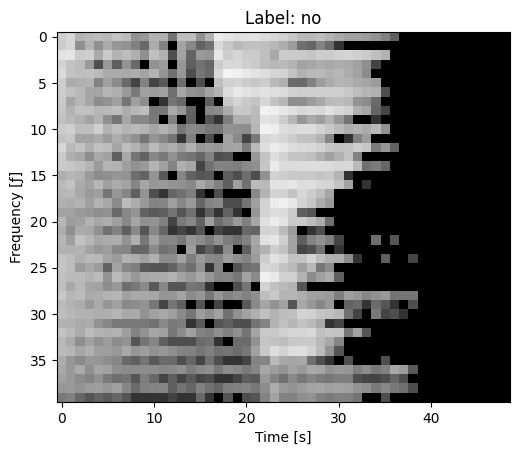

In [13]:
feature = (
    audio_processor.get_data(audio_processor.Modes.VALIDATION)
    .shuffle(100)
    .take(1)
    .get_single_element()
)
visualize_feature(feature)

## 5. Run Training

Define training procedure using the previously defined parameters.

In addition to the training hyperparamerters (training steps, learning rate,...) an optimizer (`Adam`), a loss function (`SparseCategoricalCrossentropy`) as well as a metric is selected for the training and passed to the `model.compile()` method.

The actual training happens when `model.fit()` is called. The training progress should be visible on the screen. While multiple epochs ("one pass over the entire dataset") are required for the training, the validation accuracy is evaluated every 200 steps and the weights are written to a directory automatically.

At the end of the training procedure the final test accuracy of the trained model is printed to the screen.

In [14]:
def train(model, audio_processor):
    # We decay learning rate in a constant piecewise way to help learning.
    training_steps_list = list(map(int, FLAGS.how_many_training_steps.split(",")))
    learning_rates_list = list(map(float, FLAGS.learning_rate.split(",")))
    lr_boundary_list = training_steps_list[:-1]  # Only need the values at which to change lr.
    lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=lr_boundary_list, values=learning_rates_list
    )

    # Specify the optimizer configurations.
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    # Compile the model.
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    # Prepare/split the dataset.
    train_data = audio_processor.get_data(
        audio_processor.Modes.TRAINING,
        FLAGS.background_frequency,
        FLAGS.background_volume,
        int((FLAGS.time_shift_ms * FLAGS.sample_rate) / 1000),
    )
    train_data = train_data.repeat().batch(FLAGS.batch_size).prefetch(tf.data.AUTOTUNE)
    val_data = audio_processor.get_data(audio_processor.Modes.VALIDATION)
    val_data = val_data.batch(FLAGS.batch_size).prefetch(tf.data.AUTOTUNE)

    # We train for a max number of iterations so need to calculate how many 'epochs' this will be.
    training_steps_max = np.sum(training_steps_list)
    training_epoch_max = int(np.ceil(training_steps_max / FLAGS.eval_step_interval))

    # Callbacks.
    train_dir = Path(FLAGS.train_dir) / FLAGS.model_name / "best"
    train_dir.mkdir(parents=True, exist_ok=True)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=(train_dir / (FLAGS.model_name + "_{val_accuracy:.3f}_ckpt")),
        save_weights_only=True,
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
    )

    # Train the model.
    model.fit(
        x=train_data,
        steps_per_epoch=FLAGS.eval_step_interval,
        epochs=training_epoch_max,
        validation_data=val_data,
        callbacks=[model_checkpoint_callback, *get_student_callbacks()],
    )

    # Test and save the model.
    test_data = audio_processor.get_data(audio_processor.Modes.TESTING)
    test_data = test_data.batch(FLAGS.batch_size)

    # Evaluate the model performace.
    test_loss, test_acc = model.evaluate(x=test_data)
    print(f"Final test accuracy: {test_acc*100:.2f}%")

Invoke training procedure (**Warning:** This will take a very long time!)

In [15]:
train(model, audio_processor)

Epoch 1/38
400/400 [==============================] - 11s 26ms/step - loss: 1.4446 - accuracy: 0.5115 - val_loss: 0.8748 - val_accuracy: 0.7270
Epoch 2/38
400/400 [==============================] - 10s 25ms/step - loss: 0.8116 - accuracy: 0.7392 - val_loss: 0.6452 - val_accuracy: 0.7851
Epoch 3/38
400/400 [==============================] - 11s 29ms/step - loss: 0.6739 - accuracy: 0.7804 - val_loss: 0.5388 - val_accuracy: 0.8167
Epoch 4/38
400/400 [==============================] - 12s 31ms/step - loss: 0.6137 - accuracy: 0.8001 - val_loss: 0.5320 - val_accuracy: 0.8203
Epoch 5/38
400/400 [==============================] - 12s 31ms/step - loss: 0.5531 - accuracy: 0.8188 - val_loss: 0.4698 - val_accuracy: 0.8480
Epoch 6/38
400/400 [==============================] - 12s 31ms/step - loss: 0.5073 - accuracy: 0.8349 - val_loss: 0.4247 - val_accuracy: 0.8609
Epoch 7/38
400/400 [==============================] - 12s 31ms/step - loss: 0.4735 - accuracy: 0.8455 - val_loss: 0.3955 - val_accuracy:

Determine latest checkpoint

In [16]:
latest = tf.train.latest_checkpoint(Path(FLAGS.train_dir) / FLAGS.model_name / "best")
print(latest)

training/kws_model_student/best/kws_model_student_0.926_ckpt


Pick a checkpoint

In [17]:
FLAGS.checkpoint = latest  # Feel free to choose a different one!

**Task:** Update [`student/callbacks.py`](./student/callbacks.py) to define an EarlyStopping (https://keras.io/api/callbacks/early_stopping/) callback with keras which stops the training procedure after 10 or more epochs of neglectible improvement of the `val_loss` quantity. Then rerun the training procedure.

## 6. Test trained TensorFlow model

Define test procedure we can use to evaluate our models performance.

The used test routines are defined in [`test.py`](./test.py).

In [18]:
def test(model, audio_processor, model_settings):
    """Calculate accuracy and confusion matrices on validation and test sets.

    Model is created and weights loaded from supplied command line arguments.
    """
    model.load_weights(FLAGS.checkpoint).expect_partial()

    # Get test data
    data = audio_processor.get_data(audio_processor.Modes.TESTING).batch(FLAGS.batch_size)

    # Invoke model
    predictions = model.predict(data)

    # Calculate indices
    expected_indices = np.concatenate([y for x, y in data])
    predicted_indices = tf.argmax(predictions, axis=1)

    print("Running testing on test set...")
    accuracy = get_accuracy(expected_indices, predicted_indices)
    confusion_matrix = get_confusion_matrix(expected_indices, predicted_indices, model_settings)

    # Print accuracy and confusion matrix
    print(
        f"test accuracy = {accuracy * 100:.2f}%"
        f"(N={audio_processor.set_size(audio_processor.Modes.TESTING)})"
    )
    print()
    print("confusion matrix:")
    print(confusion_matrix.numpy())

    # Print student metrics
    print()
    print("metrics:")
    words = ["silence", "unknown"] + FLAGS.wanted_words.split(",")
    for idx, label in enumerate(words):
        data = get_student_metrics(confusion_matrix, idx)

        # Filter None values
        data = {key: value for key, value in data.items() if value is not None}
        if len(data) == 0:
            continue
        print(f"  {label}:")
        for key, value in data.items():
            if isinstance(value, float):
                value = f"{value:.3f}"
            print(f"    {key} = {value}")
        print()

Run test procedure

In [19]:
test(model, audio_processor, model_settings)

40/40 [==============================] - 1s 15ms/step
Running testing on test set...
test accuracy = 91.88%(N=3915)

confusion matrix:
[[327   0   0   0   0   0   0   0   0   0]
 [  1 246   9  11   7   4  13  10  16  10]
 [  3   9 357   1   1   0  12   8   0   5]
 [  1   5   0 399   1   2   1   0   3   0]
 [  1   9   1   6 374   1   0   1   0   3]
 [  1   2   0  10   0 402   1   2   1   0]
 [  1   2   6   2   1   0 371   0   2  17]
 [  1  17   3   4   1   3   1 358  18   0]
 [  0   7   0   3   2   4   0  11 376   2]
 [  2   4   4   1   0   0  24   1   2 387]]

metrics:
  silence:
    recall = 1.000
    precision = 0.967
    f1_score = 0.983

  unknown:
    recall = 0.752
    precision = 0.817
    f1_score = 0.783

  on:
    recall = 0.902
    precision = 0.939
    f1_score = 0.920

  left:
    recall = 0.968
    precision = 0.913
    f1_score = 0.940

  right:
    recall = 0.944
    precision = 0.966
    f1_score = 0.955

  yes:
    recall = 0.959
    precision = 0.966
    f1_score = 0

Confusion matrices are also printed as they provide infomation about how the individual classes have performed.

**Task:** After completing the programming tasks in `student/metrics.py` the per-class recall, precision and f1-score will be printed above as well.

## 7. Quantization and Conversion to TFLite 

Define conversion procedure using the `TFLiteConverter` which creates a `.tflite` file which holds the model graph and constant weights.

In [20]:
NUM_REP_DATA_SAMPLES = (
    100  # Number of representative samples which will be used for the post-training quantization.
)


def convert(model, audio_processor, checkpoint, quantize, inference_type, tflite_path):
    """Load our trained floating point model and convert it.
    TFLite conversion or post training quantization is performed and the
    resulting model is saved as a TFLite file.
    We use samples from the validation set to do post training quantization.
    Args:
        model: The keras model.
        audio_processor: Audio processor class object.
        checkpoint: Path to training checkpoint to load.
        quantize: Whether to quantize the model or convert to fp32 TFLite model.
        inference_type: Input/output type of the quantized model.
        tflite_path: Output TFLite file save path.
    """
    model.load_weights(checkpoint).expect_partial()

    val_data = audio_processor.get_data(audio_processor.Modes.VALIDATION).batch(1)

    def _rep_dataset():
        """Generator function to produce representative dataset."""
        i = 0
        for mfcc, label in val_data:
            if i > NUM_REP_DATA_SAMPLES:
                break
            i += 1
            yield [mfcc]

    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    if quantize:
        # Quantize model and save to disk.
        if inference_type == "int8":
            converter.inference_input_type = tf.int8
            converter.inference_output_type = tf.int8

        # Int8 post training quantization needs representative dataset.
        converter.representative_dataset = _rep_dataset
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

    tflite_model = converter.convert()
    with open(tflite_path, "wb") as f:
        f.write(tflite_model)
    print("{} model saved to {}.".format("Quantized" if quantize else "Converted", tflite_path))

Invoke the previously defined conversion routine

In [21]:
Path(FLAGS.models_dir).mkdir(exist_ok=True)
keywords_str = FLAGS.wanted_words.replace(",", "")
tflite_path_quantized = (
    Path(FLAGS.models_dir) / f"{FLAGS.model_name}_{keywords_str}_quantized.tflite"
)
tflite_path = Path(FLAGS.models_dir) / f"{FLAGS.model_name}_{keywords_str}.tflite"

# Load floating point model from checkpoint and convert it.
convert(model, audio_processor, FLAGS.checkpoint, False, "fp32", tflite_path)

# Quantize model from checkpoint and convert it.
convert(model, audio_processor, FLAGS.checkpoint, True, "int8", tflite_path_quantized)

INFO:tensorflow:Assets written to: /tmp/tmpwupwy4nm/assets


INFO:tensorflow:Assets written to: /tmp/tmpwupwy4nm/assets
/home/almo/Programs/anaconda3/envs/esd/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-12-03 23:34:51.410447: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-12-03 23:34:51.410464: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


Converted model saved to models/kws_model_student_onleftrightyesoffdownnoup.tflite.


INFO:tensorflow:Assets written to: /tmp/tmpaa9ucixr/assets


INFO:tensorflow:Assets written to: /tmp/tmpaa9ucixr/assets
/home/almo/Programs/anaconda3/envs/esd/lib/python3.8/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-12-03 23:34:52.346577: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-12-03 23:34:52.346598: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-12-03 23:34:52.659063: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().

Quantized model saved to models/kws_model_student_onleftrightyesoffdownnoup_quantized.tflite.


## 8. Test Converted TFLite Model

Test the newly converted model on the test set.

The `tflite_test` function is defined in [`test_tflite.py`](./test_tflite.py).

**Floating Point**

In [22]:
_ = tflite_test(model_settings, audio_processor, str(tflite_path), mode="test")

Running testing on test set...


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


test accuracy = 91.78%(N=3915)

confusion matrix:
[[327   0   0   0   0   0   0   0   0   0]
 [  1 246   9  11   7   4  13  10  16  10]
 [  3  10 357   1   1   0  11   8   0   5]
 [  1   6   0 398   1   2   2   0   2   0]
 [  1  10   1   6 373   1   0   1   0   3]
 [  1   2   0  10   0 402   1   2   1   0]
 [  1   2   6   2   1   0 371   0   4  15]
 [  1  18   3   4   1   3   1 357  18   0]
 [  0   6   0   3   2   4   0  10 378   2]
 [  2   4   6   2   0   0  24   1   2 384]]


**Quantized**

In [23]:
_ = tflite_test(model_settings, audio_processor, str(tflite_path_quantized), mode="test")

Running testing on test set...
test accuracy = 91.75%(N=3915)

confusion matrix:
[[327   0   0   0   0   0   0   0   0   0]
 [  1 246   9  11   9   4  12   9  16  10]
 [  4  10 357   0   1   0  12   8   0   4]
 [  1   6   0 398   1   2   2   0   2   0]
 [  1  10   1   6 373   1   0   1   0   3]
 [  1   2   0  10   0 402   1   2   1   0]
 [  1   2   6   4   1   1 367   0   4  16]
 [  1  17   3   4   1   3   1 360  16   0]
 [  0   5   0   4   2   4   0  12 376   2]
 [  2   4   4   2   0   0  24   1   2 386]]


Interestingly the accuracy of the quantized model can be even better than the floating point one. This behavior is a consequence of the quantization procedure the TFLite which requires a `representative_dataset` to partially re-train some weights during the quantization.

## 9. Visualize TFLite Model

**Figure 1:** Example TFLite KWS Model
<img src="resources/micro_kws_xs_yesno_quantized.png" alt="Netron graph" width="150"/>

Use the following links to download the generated `.tflite` files

**Floating Point**

In [24]:
FileLink(tflite_path)

/media/almo/Windows/Users/Thien/Documents/MSNE/WS23_ESD4ML/micro-kws/1_train/models/kws_model_student_onleftrightyesoffdownnoup.tflite

**Quantized**

In [25]:
FileLink(tflite_path_quantized)

/media/almo/Windows/Users/Thien/Documents/MSNE/WS23_ESD4ML/micro-kws/1_train/models/kws_model_student_onleftrightyesoffdownnoup_quantized.tflite

Use the web application https://netron.app/ to generate a graph representation of the converted model.

## 10. Performance and Memory Estimations

In this section you will learn how to estimate the complexity of a given model architecture to evaluate if it is suitable to be deployed on a very constrained embedded device. We will also make use of some simplifications to make our life easier.

In [26]:
m = load_model(tflite_path_quantized)

### 10.1 ROM Usage

Estimating the ROM usage of model graph is non-trivial if considering all types of data which contributes to the ROM footprint e.g.

- Code size of the implementation of neural network kernels
- ROM overhead of the used inference engine/runtime
- The constant weights used by the kernels/operators
- Driver code for interfacing with peripherals such as sensors or a serial communication port
- If not running bare-metal: Additional ROM usage depending on the used operating system or RTOS

In addition the final ROM size depends on further properties such as the used compiler flags (optimization level) and certain memory alignment requirements.

Lets consider the previously trained `micro_kws_xs_yesno_quantized.tflite` model: It's file size is $10704$ bytes. However the TFLite Flatbuffer format also stores a compat representation of the models tensors (name, shape, type,...) and operators (inputs, outputs, parameters) and some metadata alongside with the model weights which contribute to the biggest part of the file.

In the following we will only consider the actual weights used by the model, hence we can ignore any implementation specific overheads.

The used tensor datatypes (specifically `float32`, `int8` or `int32`) per operator have to be investigated to calculate the total amount of RAM required by the model weights. The https://netron.app/ can be used for this task.

**Task:** Derive a formula to estimate the memory requirement to store all constant weights of the quantized model in ROM considering the used data types.

**Task:** Update the `estimate_rom` utility in [`student/estimate.py`](./student/estimate.py) to use your derived formula.

Execute the following cell to test run your implementation:

In [27]:
estimated_rom = estimate_model_rom(m)
print(f"Estimated ROM Usage: {estimated_rom/1e3:.3f} KiB")

Estimated ROM Usage: 17.088 KiB


### 10.2 RAM Usage

Investigating the RAM usage of a given model involves similar challenges as the ROM-estimations.

RAM requirements can vary a lot with the chosen model architecture and deployment flow. The largest contribution to the RAM footprint are often intermediate tensor buffers (activations) but also temporary scratchpad memory required by certain kernel implementations.

Optionally memory planning can be used to reduce the RAM usage by analysing the lifetime of certain input and output buffers. This process can happen during runtime (online) or statically (offline) depending on deployment approach.

Again additional application-specifc overheads might also be non-negligible.

**Task:** Derive formulars for estimating the dynamic memory requirement of the quantized model based on the TFLite graph only considering intermediate tensor buffers stored in RAM for optimal memory-planning.

*Assumptions:*
- Neither branches nor nodes with multiple inputs/outputs extist in the trained model.
- Assume that the graph is processed in a linear way so that at most 2 buffers will be used at the same time.

**Task:** Update the `estimate_ram` utility in [`student/estimate.py`](./student/estimate.pyestimate_rom) to use your derived formulas.

Execute the following cell to test run your implementation:

In [28]:
estimated_ram = estimate_model_ram(m)
print(f"Estimated RAM Usage: {estimated_ram/1e3:.3f} KiB")

Estimated RAM Usage: 78.080 KiB


### 10.3 Number of MAC Operations

In this section the compute demand of a given TFLite model should be estimated.

As a first simplification we will only consider the operation which will have the biggest impact on the actual inference time: Multiply-Add (MAC)

These operations can be found in Dense (FullyConnected), and convolutional layers. Thus other operations (here: Reshape, Flatten as well as activation functions) can be neglected for the following task.

First, a formular to describe the number of MAC operations of the three major types of with repect to the given tensor dimensions and parameters.

**Example (Dense/FullyConnected):**

  Assume: $h_{out}=h_{in}$, $w_{out}=w_{filter}$

  $$num_{mac} = h_{out} \cdot w_{out} \cdot h_{filter}$$
  
  For the example keras model: $1 \cdot 4 \cdot 2000 \approx 8k \mathrm{MACs}$

**Task:** Estimate the number of Multiply-Add operations used in the quantized model (see Figure 1) by deriving a formula for `num_mac` in a (depthwise) convolutional layer with respect to $$h_{kernel}, w_{kernel}, c_{in}, c_{out}, h_{out}, w_{out}$$ and (if applicable) $$depth\_multiplier,h_{stride}, w_{stride}$$.

**Task:** Update the `estimate_fully_connected`, `estimate_conv2d_macs` and `estimate_depthwise_conv2d_macs` in [`student/estimate.py`](./student/estimate.py) to use your derived formulas.

Execute the following cell to test run your implementation:

In [29]:
estimated_macs = estimate_model_macs(m)
print(f"Estimated MACs: {estimated_macs}")

Estimated MACs: 2218624


## 11. Final challenge

**Task:** To get bonus credits in the lab you have to design a model architecture for the keyword-spotting task which satisfies each of the following constraints:

See `Lab 1 Manual`!

## 12. Lab 1 Submission

The following cell can be executed to run some basic tests on your code. The converage of these unit tests is far away from complete and 100% successful tests to not imply a correct solution.

In [30]:
!python -m pytest tests/

============================= test session starts ==============================
platform linux -- Python 3.8.18, pytest-7.4.3, pluggy-1.3.0
rootdir: /media/almo/Windows/Users/Thien/Documents/MSNE/WS23_ESD4ML/micro-kws/1_train
configfile: pytest.ini
plugins: anyio-4.0.0
collected 7 items                                                              

tests/test_callbacks.py .                                                [ 14%]
tests/test_estimate.py ...                                               [ 57%]
tests/test_metrics.py ...                                                [100%]

============================== 7 passed in 1.10s ===============================


After completing the lab execises, the following cell can be executed to generate the ZIP file containing the expected files. This script also runs some basic checks to make sure that nothing is missing in your submission. The `submission.zip` file has to be uploaded to Moodle before the deadline.

In [32]:
!python submit.py

Creating archive: submission_1.zip

Adding file: student/names.txt
Adding file: student/words.txt
Adding file: student/model.py
Adding file: student/callbacks.py
Adding file: student/metrics.py
Adding file: student/estimate.py
Adding file: models/kws_model_student_onleftrightyesoffdownnoup.tflite
Adding file: models/kws_model_student_onleftrightyesoffdownnoup_quantized.tflite

Done. Please upload the submission_1.zip file to Moodle!


This is the end of the Notebook.